In [1]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
np.random.seed(0)

In [3]:
os.chdir("../../data")

In [4]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [5]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [6]:
def read_xml(file, username):
    import xml.etree.ElementTree as ET

    xml_data = open(file, "r").read()  # Read file
    root = ET.XML(xml_data)  # Parse XML

    data = []
    cols = []
    for i, child in enumerate(root):
        data.append([subchild.text for subchild in child])
        cols.append(child.tag)
    new_list = pd.DataFrame(data).T
    new_list.columns = cols

    df = new_list.loc[[0, 9]].T.dropna().rename({0: "anime_id", 9: "my_score"}, axis=1)
    df["username"] = username
    df["anime_id"] = df["anime_id"].astype(int)
    df["my_score"] = df["my_score"].astype(int)
    df["username"] = df["username"].astype(str)
    df = df.loc[lambda x: x["my_score"] != 0]
    df = df.reset_index(drop=True)
    return df


def add_user(full_df, xml_file, username):
    user_df = read_xml(xml_file, username)
    without_user = full_df.loc[lambda x: x["username"] != username]
    return pd.concat([without_user, user_df], ignore_index=True)

In [7]:
filtered_df = add_user(filtered_df, "user_profiles/Fro116.xml", "Fro116")

In [8]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [9]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [10]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [11]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [12]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605473,0.605473
karthiga,59,7,0.040203,-0.059898,-0.474166,-0.474166
karthiga,74,7,0.316283,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227338,-0.059898,-0.206624,-0.206624


In [13]:
all_corrs = pickle.load(open("item_correlations/correlations.pkl", "rb"))
all_corrs["similarity"] = all_corrs["corr"].abs()
all_corrs = all_corrs.dropna()
all_corrs = all_corrs.loc[
    lambda x: x.index.get_level_values("anime_id_x")
    != x.index.get_level_values("anime_id_y")
]
all_corrs = all_corrs.sort_values(by="similarity")

In [14]:
def compute_accuracy_metrics(
    is_df, oos_df, corrs, recommendee, neighborhood_sizes, full_neighborhoods
):
    anime_var = (
        pd.DataFrame(is_df.groupby("anime_id")["normalized_score"].var())
        .rename({"normalized_score": "anime_var"}, axis=1)
        .dropna()
    )
    user_var = (
        pd.DataFrame(is_df.groupby("username")["normalized_score"].var())
        .rename({"normalized_score": "user_var"}, axis=1)
        .dropna()
    )
    
    if full_neighborhoods:
        all_score = is_df.loc[recommendee].merge(
            corrs.reset_index("anime_id_x"), left_on="anime_id", right_on="anime_id_y"
        )
        all_score["user_var"] = user_var.loc["Fro116"].squeeze()
        all_score = all_score.merge(anime_var, on="anime_id")
        all_score = all_score.drop("anime_id", axis=1).rename(
            {"anime_id_x": "anime_id"}, axis=1
        )        

    metrics = pd.DataFrame()
    for neighborhood_size in reversed(sorted(neighborhood_sizes)):
        # extract model features
        if full_neighborhoods:
            score = (
                all_score.groupby("anime_id").tail(neighborhood_size).reset_index(drop=True)
            )
        else:
            corrs = corrs.groupby("anime_id_x").tail(neighborhood_size)

            score = is_df.loc[recommendee].merge(
                corrs.reset_index("anime_id_x"), left_on="anime_id", right_on="anime_id_y"
            )
            score["user_var"] = user_var.loc["Fro116"].squeeze()
            score = score.merge(anime_var, on="anime_id")
            score = score.drop("anime_id", axis=1).rename(
                {"anime_id_x": "anime_id"}, axis=1
            )
        pred_df = prepare_prediction(recommendee, score)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "full_neighborhoods": full_neighborhoods,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [15]:
%%time
from tqdm import tqdm

recommendee = "Fro116"
K = 10
base = 2

errors_by_neighborhood_size = []
max_size = len(filtered_df.anime_id.unique())
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(max_size) / np.log(base)) + 1)
] + [max_size]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)
for split in splits:
    display(split.head())

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies as a safety precaution
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), all_corrs.copy(), "Fro116", neighborhood_sizes, False
        )
    )

    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), all_corrs.copy(), "Fro116", neighborhood_sizes, True
        )
    )

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,256,6,-0.007109,-1.027193,-0.459558,-0.459558
Fro116,33161,8,0.598972,-1.027193,0.934361,0.934361
Fro116,2724,8,0.041059,-1.027193,1.492275,1.492275
Fro116,33206,6,0.604474,-1.027193,-1.071141,-1.071141
Fro116,16001,8,0.632340,-1.027193,0.900994,0.900994


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,16,7,0.598092,-1.027193,-0.064759,-0.064759
Fro116,431,6,1.143566,-1.027193,-1.610233,-1.610233
Fro116,12115,6,0.730296,-1.027193,-1.196963,-1.196963
Fro116,218,6,0.060687,-1.027193,-0.527354,-0.527354
Fro116,396,9,0.347029,-1.027193,2.186304,2.186304


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,22687,6,-0.733812,-1.027193,0.267145,0.267145
Fro116,15617,5,-0.278302,-1.027193,-1.188365,-1.188365
Fro116,82,8,0.281751,-1.027193,1.251582,1.251582
Fro116,10162,7,1.082352,-1.027193,-0.549019,-0.549019
Fro116,5630,5,0.605685,-1.027193,-2.072352,-2.072352


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,35557,8,0.771315,-1.027193,0.762018,0.762018
Fro116,2924,5,0.642192,-1.027193,-2.108858,-2.108858
Fro116,879,6,-0.073983,-1.027193,-0.392684,-0.392684
Fro116,35838,8,0.483119,-1.027193,1.050215,1.050215
Fro116,5196,6,-0.278285,-1.027193,-0.188381,-0.188381


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,35851,4,0.682818,-1.027193,-3.149485,-3.149485
Fro116,1889,6,0.949183,-1.027193,-1.415850,-1.415850
Fro116,12113,5,0.457188,-1.027193,-1.923855,-1.923855
Fro116,9760,6,0.210068,-1.027193,-0.676735,-0.676735
Fro116,40591,7,-0.493860,-1.027193,1.027193,1.027193


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,36539,7,-0.352044,-1.027193,0.885378,0.885378
Fro116,14813,9,0.507691,-1.027193,2.025642,2.025642
Fro116,22101,6,0.185061,-1.027193,-0.651728,-0.651728
Fro116,160,6,0.233831,-1.027193,-0.700498,-0.700498
Fro116,11843,6,0.757073,-1.027193,-1.223739,-1.223739


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,33489,7,0.534100,-1.027193,-0.000766,-0.000766
Fro116,6114,6,0.962570,-1.027193,-1.429237,-1.429237
Fro116,490,6,-0.058828,-1.027193,-0.407839,-0.407839
Fro116,1033,5,0.806017,-1.027193,-2.272683,-2.272683
Fro116,25519,9,-0.130003,-1.027193,2.663336,2.663336


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,8769,8,-0.013330,-1.027193,1.546663,1.546663
Fro116,2034,5,0.701908,-1.027193,-2.168574,-2.168574
Fro116,5081,5,0.825437,-1.027193,-2.292104,-2.292104
Fro116,24629,6,-0.792416,-1.027193,0.325750,0.325750
Fro116,31764,5,0.235046,-1.027193,-1.701713,-1.701713


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,9055,7,-0.259060,-1.027193,0.792394,0.792394
Fro116,15911,5,-0.176364,-1.027193,-1.290303,-1.290303
Fro116,16664,8,0.760470,-1.027193,0.772864,0.772864
Fro116,189,6,-0.281496,-1.027193,-0.185171,-0.185171
Fro116,81,7,0.565557,-1.027193,-0.032224,-0.032224


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,24765,8,0.028793,-1.027193,1.504540,1.504540
Fro116,37171,5,-2.493860,-1.027193,1.027193,1.027193
Fro116,6547,6,0.811402,-1.027193,-1.278069,-1.278069
Fro116,31043,8,0.939692,-1.027193,0.593641,0.593641
Fro116,7645,7,0.273471,-1.027193,0.259863,0.259863


100%|██████████| 10/10 [1:32:15<00:00, 553.59s/it]

CPU times: user 57min 11s, sys: 26min 8s, total: 1h 23min 20s
Wall time: 1h 32min 21s


In [16]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [17]:
allerrors

,full_neighborhoods,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse
0,0.0,0.913947,1.526120,14088.0,0.947368,1.310829
1,0.0,0.913947,1.525689,8192.0,0.947368,1.309592
2,0.0,0.913947,1.527326,4096.0,0.947368,1.310157
3,0.0,0.910979,1.518791,2048.0,0.947368,1.295374
4,0.0,0.908012,1.507677,1024.0,0.947368,1.271906
...,...,...,...,...,...,...
295,1.0,0.920118,1.558824,16.0,0.891892,1.921506
296,1.0,0.920118,1.566484,8.0,0.891892,1.950334
297,1.0,0.920118,1.572060,4.0,0.891892,1.956329
298,1.0,0.920118,1.572703,2.0,0.891892,1.957273


In [18]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "full_neighborhoods"])

In [19]:
wide_data.loc[lambda x: x.full_neighborhoods == True, "variable"] = (
    "full_" + wide_data.loc[lambda x: x.full_neighborhoods == True, "variable"]
)

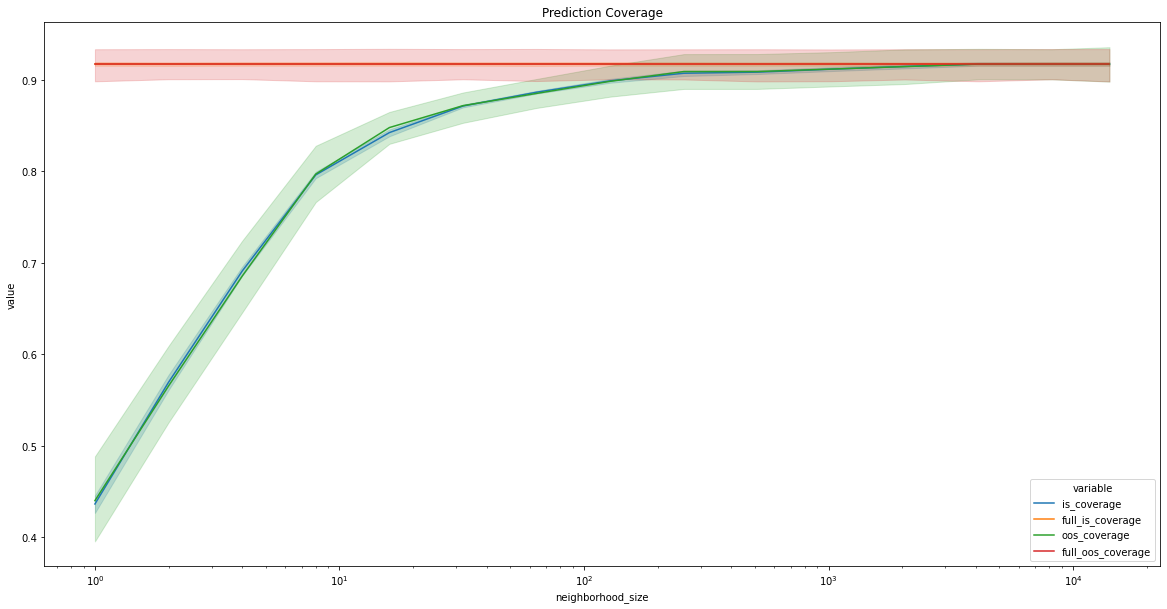

In [20]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

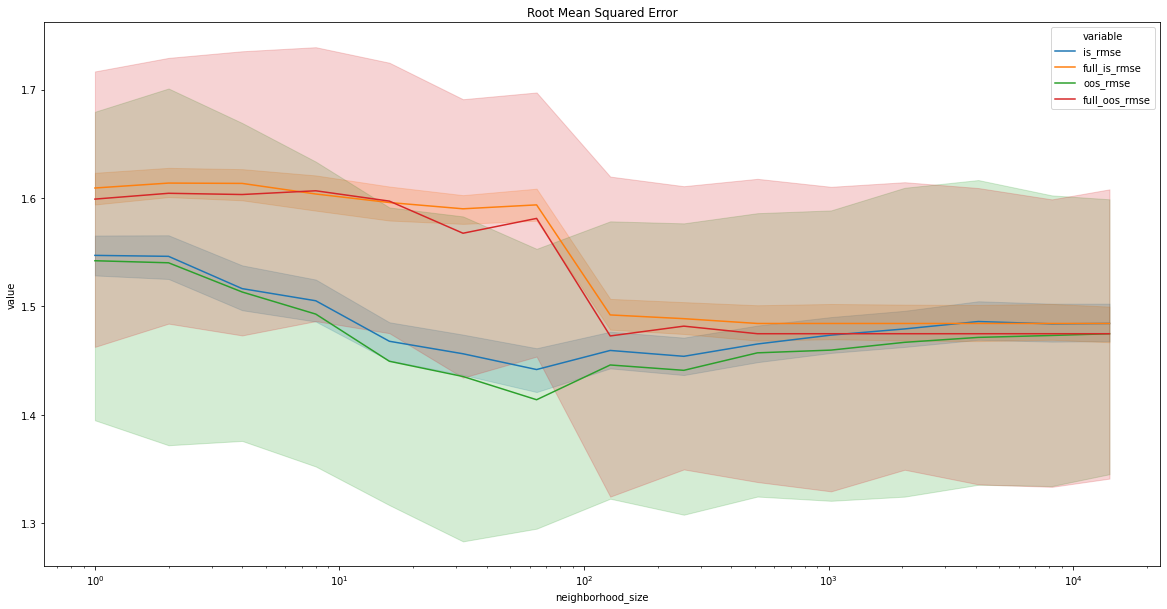

In [21]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [22]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["full_neighborhoods", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
full_neighborhoods neighborhood_size                                               
0.0                64.0                  0.886518  1.441805      0.885206  1.413945
                   32.0                  0.871408  1.456371      0.871835  1.435391
                   256.0                 0.907255  1.454019      0.909104  1.441082
                   128.0                 0.898961  1.459427      0.898435  1.446026
                   16.0                  0.842371  1.467897      0.847866  1.449441
                   512.0                 0.908441  1.465394      0.909104  1.457231
                   1024.0                0.911701  1.473584      0.911807  1.459750
                   2048.0                0.914665  1.479294      0.914509  1.466935
                   4096.0                0.917332  1.486123      0.917212  1.471478
1.0                128.0                 0.917332  1.492208      0.917212  1.472813

In [23]:
# My takeaway from this is that it doesn't matter if we normalize variance or not
# For simplicity, let's forgo normalization

In [24]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["full_neighborhoods", "neighborhood_size"]).mean().xs(
    0, level="full_neighborhoods"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
64.0,0.886518,1.441805,0.885206,1.413945
32.0,0.871408,1.456371,0.871835,1.435391
256.0,0.907255,1.454019,0.909104,1.441082
128.0,0.898961,1.459427,0.898435,1.446026
16.0,0.842371,1.467897,0.847866,1.449441
512.0,0.908441,1.465394,0.909104,1.457231
1024.0,0.911701,1.473584,0.911807,1.459750
2048.0,0.914665,1.479294,0.914509,1.466935
4096.0,0.917332,1.486123,0.917212,1.471478


In [25]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["full_neighborhoods", "neighborhood_size"]).mean().xs(
    1, level="full_neighborhoods"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
128.0,0.917332,1.492208,0.917212,1.472813
512.0,0.917332,1.484332,0.917212,1.474864
1024.0,0.917332,1.484332,0.917212,1.474864
2048.0,0.917332,1.484332,0.917212,1.474864
4096.0,0.917332,1.484332,0.917212,1.474864
8192.0,0.917332,1.484332,0.917212,1.474864
14088.0,0.917332,1.484332,0.917212,1.474864
256.0,0.917332,1.488762,0.917212,1.481854
32.0,0.917332,1.590157,0.917212,1.567603
